# №1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
def u0_creater(u):
    U = np.zeros(len(u)*2 - 2)
    for i in range(len(u) - 1):
        if i % 2 == 0:
            U[2*i] = u[i]
        else:
            U[2*i - 1] = (u[i-1] + u[i+1])/2
    U[-1] = u[-1]
    return U

In [3]:
def diff_scheme(u, lambd):
    return ( u[2] - u[1] )*(k0 + k1*(u[1]**2 + u[2]**2)/2) - \
                (u[1] - u[0])*(k0 + k1*( u[1]**2 + u[0]**2 )/2) + h**2 * lambd * u[1]

    
def board_cond(u, N):
    return u[int(N/2) ] - u[int(N/2) - 2] - 2*h


def right_part(x, u):
    
    N = len(u) - 1
            
    F_1 = diff_scheme([0, u[0], u[1]], u[-1])
    F_k = [ diff_scheme(u[i-1:i+2], u[-1]) for i in range(1, N - 1) ]
    F_N = diff_scheme([u[N-2], u[N-1], 0], u[-1])
    
    F = np.append( F_1, F_k )
    F = np.append( F, F_N )
    F = np.append( F, board_cond(u, N))
    
    return F


def jacobian_f(F, x, u, h):
    
    dim = len(u)
    
    J = np.zeros((dim, dim))
    du = np.eye(dim) * h
    
    lines_J = [(right_part(x, u + du[dd]) - \
                 right_part(x, u - du[dd]))/2/h for dd in range(dim)]
    
    J = [ line for line in lines_J]
        
    return np.array(J).transpose()


def Newton_method(x, u, N):
    
    h = 1e-5    
    #plt.figure(figsize = (17, 8))
    
    X = x
    U = np.zeros(len(u))
    
    lambd = u[-1]
    x = x[1:-1]
    u = u[1:-2]
    u = np.append(u, lambd)
        
    for i in range(20):
        
        F = right_part(x, u)
        J = jacobian_f(F, x, u, h)
                
        v = LA.solve(J, -F)        
        #print(str(i+1)+') Norm v =', LA.norm(v))
        
        u = v + u
        
        U[1:-2] = u[:-1]
        U[-1] = u[-1]
        
        #plt.plot(X, U[:-1], color = np.random.rand(3), label = 'Iteration ' + str(i+1))
                 
        if LA.norm(v) < 1e-12:
            break
     
    #plt.title(r'$N = $'+ str(N), fontsize = 20)
    #plt.xlabel('x', fontsize = 20)
    #plt.ylabel('u(x)', fontsize = 20)
    #plt.grid()    
    #plt.legend(loc = 'best', fontsize = 16)
    
    #plt.show()    
        
    return U

In [4]:
%%time

lambd_0 = 40
k0 = 1
k1 = 0.5
N = [2**i for i in range(3, 10)]
hh = [1/n for n in N]

x = [[ j/n for j in range(n+1)] for n in N]
u0 = [0, -0.1, -0.2, -0.1, 0, 0.1, 0.2, 0.1, 0, 40]

#u0 = np.append(u0, lambd_0)

#u0[-1] = lambd_0

U = [ [] for n in N ]
lambd = np.zeros(len(N))


for i, xx in enumerate(x):
    
    h = hh[i]
    #print(xx, len(u0))
    u0 = Newton_method(xx, u0, N[i])
    
    U[i] = u0
    u0 = u0_creater(u0)
    lambd[i] = u0[-1]

Wall time: 17.5 s


## Построить график $\lambda$ от номера расчета

1) 37.87084113000705
2) 39.13687479293063
3) 39.484528904017864
4) 39.57284071373877
5) 39.59500035291028
6) 39.6005452867119
7) 39.601931832918645


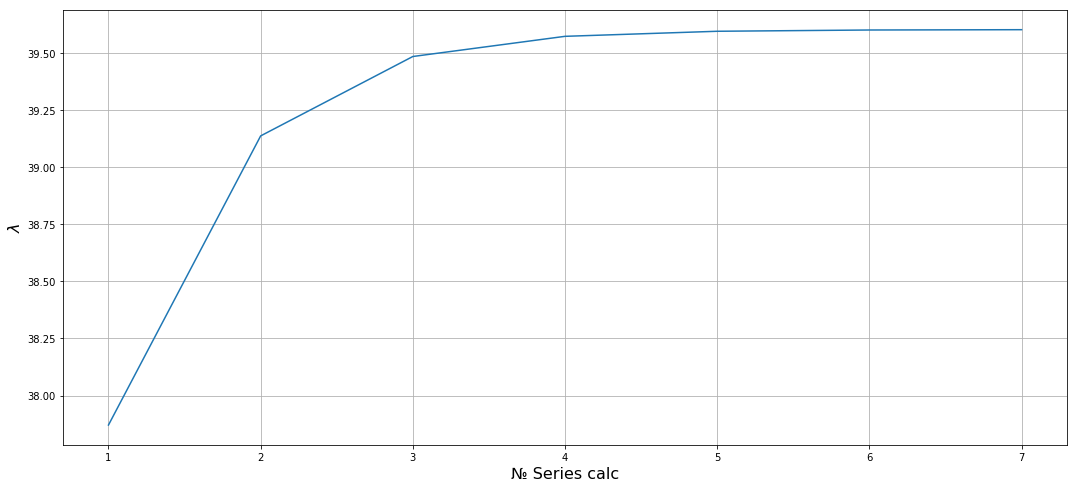

In [5]:
num = range(1,len(lambd) + 1)
for i in range(len(lambd)):
    print(str(i+1)+') ' + str(lambd[i]))

plt.figure(figsize=(18,8))
plt.plot(num, lambd)
plt.grid()
plt.xlabel('№ Series calc', fontsize = 16)
plt.ylabel(r'$\lambda$', fontsize = 16)

plt.show()

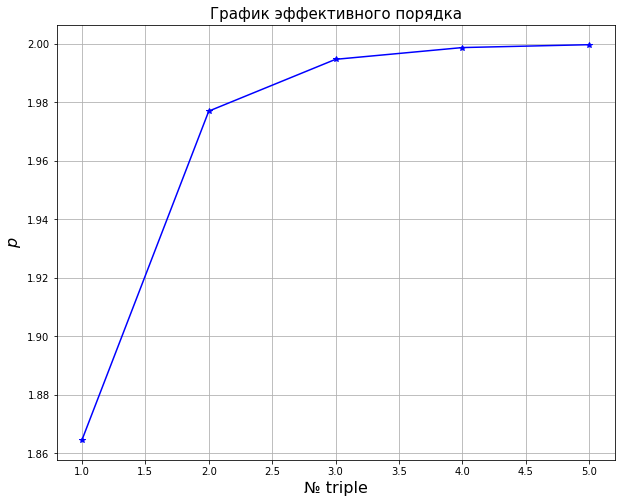

In [6]:
def effective_order_of_method(U,r,
                              lable = 'График эффективного порядка',
                              draw_flag = False):
    try:
        
        if len(U) < 3:
            raise IndexError()
      #  exp_p = [ (U[i]-U[i+1])/(U[i+1]-U[i+2]) for i in range(len(U)-2) ]
        exp_p = [ (U[i+2]-U[i+1])/(U[i+1]-U[i]) for i in range(len(U)-2) ]
        p = np.log(exp_p)/np.log(r)
        

        if draw_flag:
            plt.figure(figsize=(10,8))
            plt.plot(range(1,len(p)+1), p,'b*-')    
            plt.grid()
            plt.xlabel('№ triple',fontsize=16)
            plt.ylabel(r'$p$',fontsize=16)
            plt.title(lable,fontsize=15)
            plt.show()
            
        return p
        
    except IndexError:
        print('More than three values are required\n',traceback.format_exc())
        return None

values_eff = effective_order_of_method(lambd, 1/2., draw_flag=True)    

## Апостериорная оценка погрешности

In [7]:
def Richardsons_clarification(x, u, N_set):

    p = 2
    r = 1/2
    N = [2**i for i in range(1,9)]
    U_total = []
    
    for ind in range(len(N)-1):
        
        
        U_h = Newton_method(x, u, N_set)
        U_rh = Newton_method(x, u, N_set*r)
        
        R_rh = ( U_rh - U_h )/( r**(-p) - 1 )
        
        #print(str(ind+1)+') R_rh = ' + R_rh)
        
        U_total.append( U_rh + R_rh )
    
    return U_total[-1]

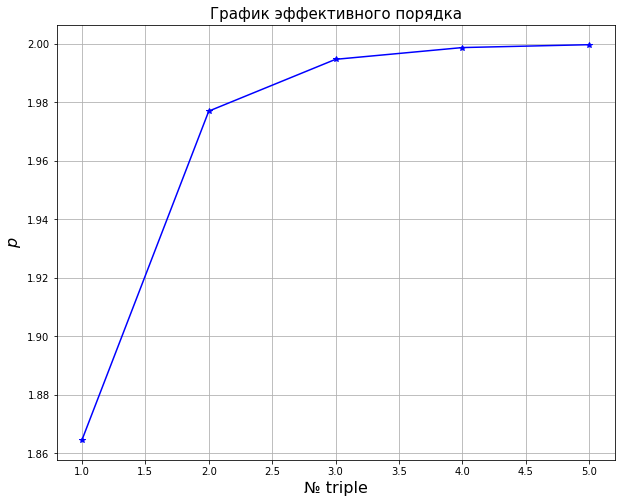

Wall time: 4min 21s


In [8]:
%%time

lambd_0 = 40
k0 = 1
k1 = 0.5
N = [2**i for i in range(3, 10)]
hh = [1/n for n in N]

x = [[ j/n for j in range(n+1)] for n in N]
u0 = [0, -0.1, -0.2, -0.1, 0, 0.1, 0.2, 0.1, 0, 40]

U = [ [] for n in N ]
lambd = np.zeros(len(N))

for i, xx in enumerate(x):
    
    h = hh[i]
    
    u0 = Richardsons_clarification(xx, u0,  N[i])
                  
    U[i] = u0
    u0 = u0_creater(u0)
    lambd[i] = u0[-1]
    
values_eff = effective_order_of_method(lambd, 1/2., draw_flag=True) 

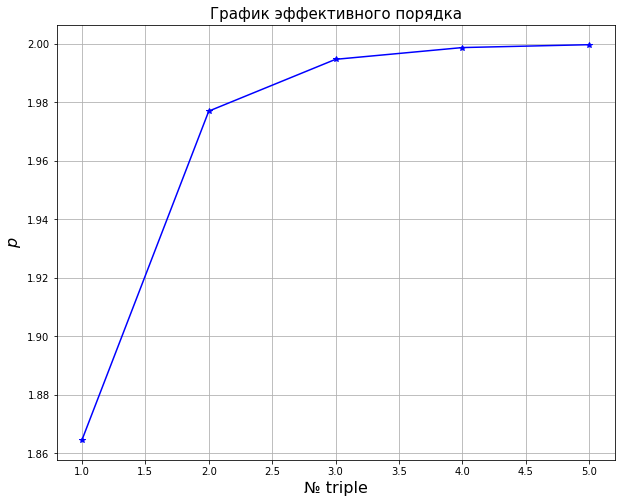

[39.60041360771361, 39.60227798364574, 39.60238689930079, 39.6023935979791, 39.60239401498756]


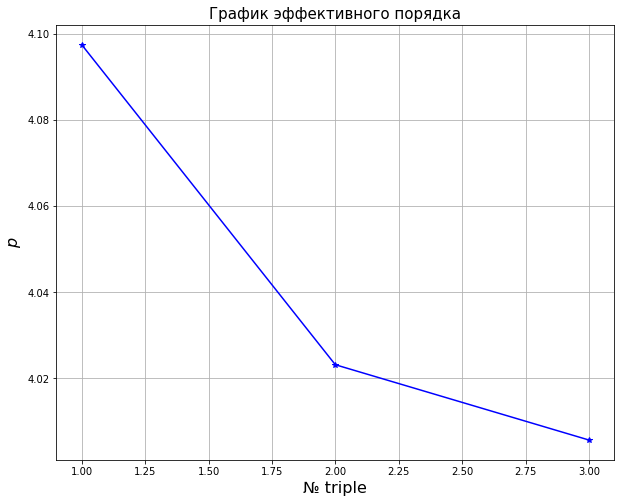

[39.60239416034446, 39.602394044557656, 39.60239404278812]


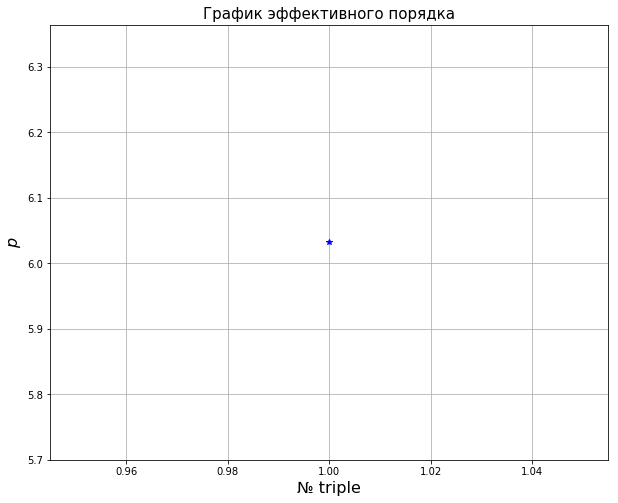

[39.60239404276003]


In [9]:

N = [2**i for i in range(1,9)]


def clar(U,p):
    r = 1/2

    U_total = []
    for ind in range(len(U)-1):

        U_h = U[ind]
        U_rh = U[ind+1]

        U_total.append( ( r**(-p)*U_rh - U_h )/( r**(-p) - 1 ) )
        
    return U_total[1:]


plt.figure(figsize = (18, 7) )

uu = U
ll = lambd

for i in range(3):
    
    values_eff = effective_order_of_method(ll, 1/2., draw_flag=True) 
    p = 2*(i+1)
    ll = clar(ll, p)            
    print(ll)
